In [31]:
import importlib
import plot
importlib.reload(plot)


<module 'plot' from '/home/yunzhu/github/neural-network-teach-in/plot.py'>

At this point, we've all heard of a neural network, and we've all  used them before, most likely for super academically integrous purposes. But what exactly is a neural network, and how does it work under the hood? Keep reading to find out!

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import plot


### What Is a Neural Network Made Of?

Before diving into the specific network we're using, here's a quick overview of the key components of any neural network:

#### Layers
Neural networks are made up of layers — these are the stages where data is processed.

- **Input layer**: This is where data enters the network. Each neuron in the input layer represents one feature from the dataset.
- **Hidden layers**: These are the layers between the input and output. They perform most of the computation, identifying patterns and relationships in the data.
- **Output layer**: This produces the final result, such as a classification label or a prediction.

#### Neurons
Each neuron receives input, performs a calculation (usually a weighted sum of its inputs plus a bias), and passes the result through an activation function. The output is then sent to neurons in the next layer.

#### Weights
Weights are values that determine how much influence one neuron has on another. Larger weights mean stronger influence. The network learns by adjusting these weights to minimize error.

#### Biases
Biases allow the network to shift the activation of neurons. They provide flexibility by enabling neurons to activate even when the weighted sum of inputs is zero.

##### An example of how weights and biases work:

![perceptron model](perceptron_model.png)  



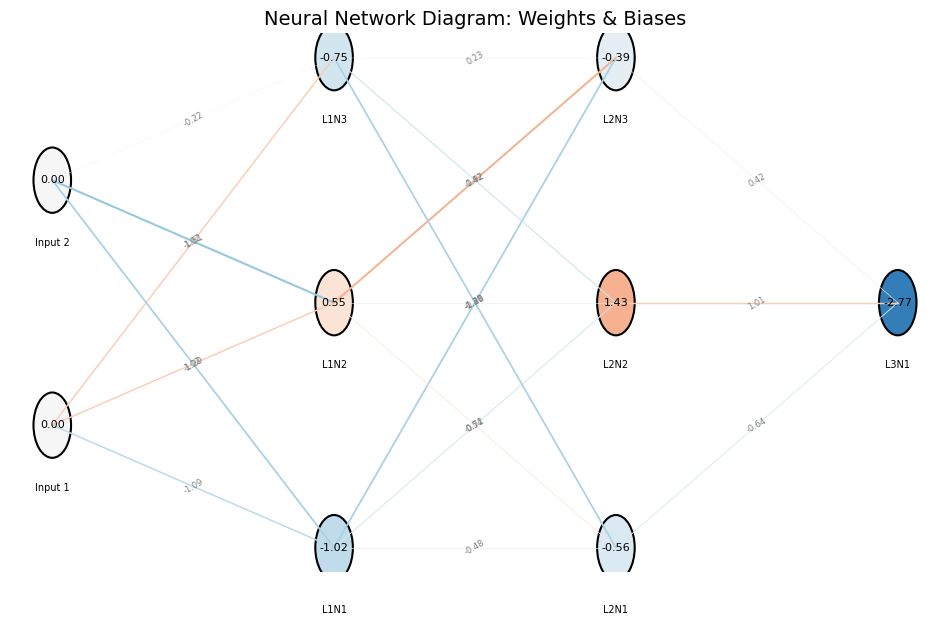

In [33]:
L = 3
n = [2, 3, 3, 1]


W1 = np.random.randn(n[1], n[0])
W2 = np.random.randn(n[2], n[1])
W3 = np.random.randn(n[3], n[2])
b1 = np.random.randn(n[1], 1)

b2 = np.random.randn(n[2], 1)
b3 = np.random.randn(n[3], 1)

weights = [W1, W2, W3]
biases = [b1, b2, b3]

plot.draw_network(n, weights, biases)

This neural network has four layers: an input layer, two hidden layers, and an output layer. The input layer has 2 neurons (representing the two input features), each hidden layer has 3 neurons, and the output layer has 1 neuron.

Each layer is made up of neurons, which are connected to the next layer by weights. These weights determine how much influence one neuron has on the next. Every neuron also has a bias, which helps shift the output of the neuron up or down. During training, the network learns by adjusting these weights and biases to better match the correct output.

The structure you see in the plot is a visual representation of the network: neurons are circles, connections are lines, and their colors represent the values of the weights and biases.

/home/yunzhu/github/neural-network-teach-in/plot.py:151: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


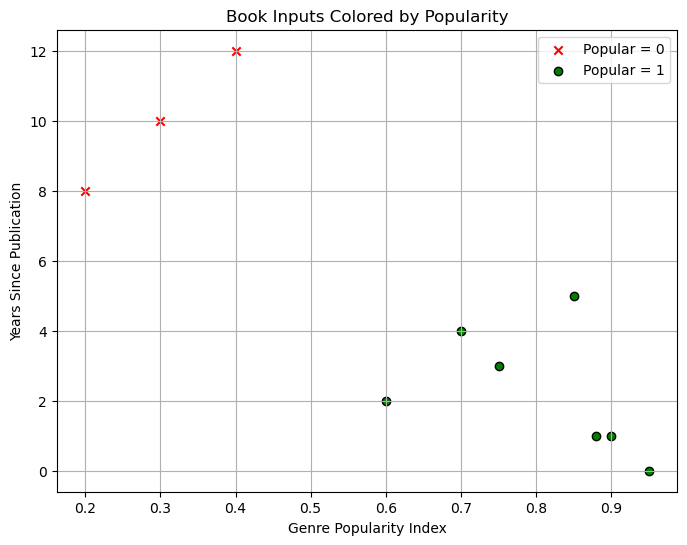

In [34]:
# X: [Genre Popularity Index, Years Since Publication]
X = np.array([
  [0.90, 1],
  [0.75, 3],
  [0.30, 10],
  [0.85, 5],
  [0.60, 2],
  [0.95, 0],
  [0.40, 12],
  [0.70, 4],
  [0.20, 8],
  [0.88, 1]
])
# y: 1 = popular, 0 = not popular
y = np.array([1, 1, 0, 1, 1, 1, 0, 1, 0, 1])
m = 10
A0 = X.T
Y = y.reshape(n[L], m)

plot.plot_inputs_by_output(A0, y)


#### Activation function
Before walking into the actual feed forward process through layers, there's another very important feature in neural networks: activation functions, which do two things:
- Introduce non-linearity, so that the network is not doing linear calculation like mx + b all the time;
- Compress the input to a predetermined range, like 0 to 1, so that it is standarized.

One common activation function that we'll be using is the sigmoid, which squeezes numbers into 0-1 range that represents a probability as output.
$$
g(x) = \frac{1}{1 + e^{-x}}
$$

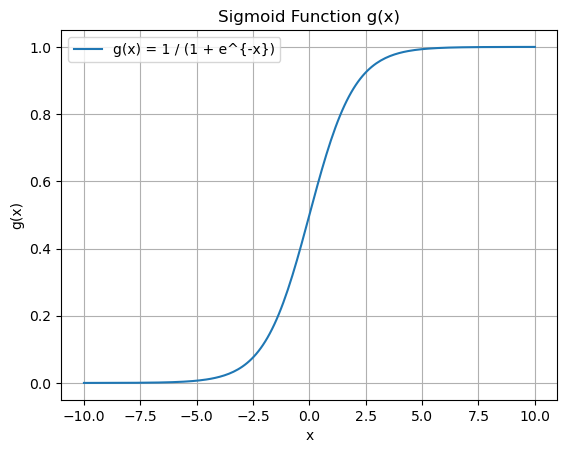

In [35]:
def g(z):
  return 1 / (1 + np.exp(-1 * z))
plot.draw_g()


With that, we are now able to understand how one feed forward layer works:

##### An exapmle of one feed forward layer:

![complete perceptron model](complete_model.png)

#### Equations

$
z_{[l]} = W_{[l]} \, a_{[l-1]} + b_{[l]}
$

$
a_{[l]} = g(z_{[l]}) \quad (0 < a_{[l]} < 1)
$

where:

- **a[l]** (*activation vector*): output of neurons after applying the activation function at layer \(l\).
- **z[l]** (*weighted input*): output before applying the activation function at layer \(l\), or the linear combination of activations from the previous layer.
- **W[l]** (*weight matrix*): all weights for connections from layer \(l-1\) to layer \(l\).
- **b[l]** (*bias vector*): all biases added at layer \(l\).
- **g()** (*activation function*): the sigmoid function in our case


In short: the input layer feeds in the data, hidden layers transform it using weights, biases and activation function, and the output layer delivers the final prediction. 


In [36]:
def feed_forward(A0):
  # layer 1 calculations
  Z1 = W1 @ A0 + b1
  A1 = g(Z1)

  # layer 2 calculations
  Z2 = W2 @ A1 + b2
  A2 = g(Z2)

  # layer 3 calculations
  Z3 = W3 @ A2 + b3
  A3 = g(Z3)

  cache = {
      "A0": A0,
      "A1": A1,
      "A2": A2
  }

  return A3, cache

### Backpropagation
After the feedforward process computes the output of the network using a randomly generated weights and biases, the next step is to evaluate how good that output is and adjust itself to make it better. This is what we call the backpropagation.

#### Cost
A cost function measures how far off the network's predictions are from the actual answers. It takes the network's output and compares it to the true labels, returning a number — the cost — that tells us how "bad" the predictions are. The lower, the better, and a cost of 0 indicates that your neural network made no mistakes.

We choose the binary cross entropy loss function as the cost function for our model:

$
L(\hat{y}_i, y_i) = - \left( y_i \ln \hat{y}_i + (1 - y_i) \ln (1 - \hat{y}_i) \right)
$

This is because:
1) the function is continuous, differentiable, and has no local maximun or minimum, which makes it very friendly for optimization
2) the loss approaches 0 when y and y_hat gets closer

Since our ground truth labels y are binary (either 0 or 1), plotting the loss against y_hat for y = 1 and y = 0 can illustrate this pattern very clearly:

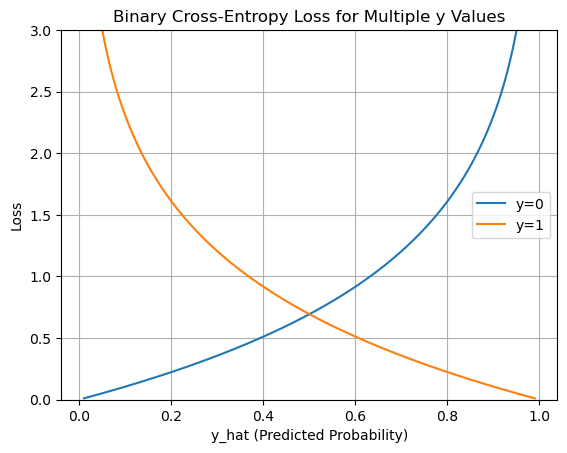

In [37]:
plot.draw_cost_function()

Now we can expand the cost function for a single pair of y and y_hat to the entire vectors:

$
C = \frac{1}{m} \sum_{i=1}^{m} L(\hat{y}_i, y_i) 
$
(Cost over all training samples)



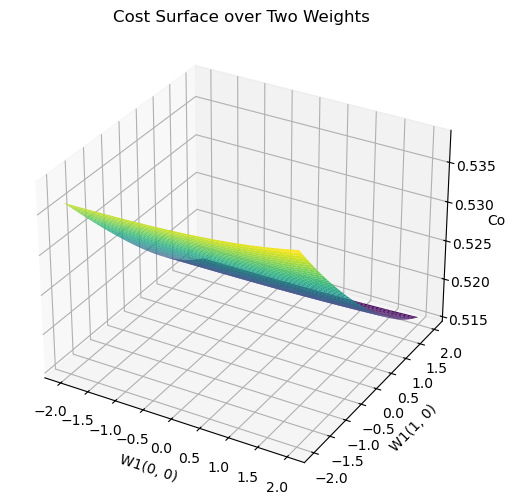

In [44]:
plot.plot_cost_surface(A0, Y, feed_forward, cost, W1)
# I WILL FIX THIS GRAPH!

In [38]:
def cost(y_hat, y):
  """
  y_hat should be a n^L x m matrix
  y should be a n^L x m matrix
  """
  # 1. losses is a n^L x m
  losses = - ( (y * np.log(y_hat)) + (1 - y)*np.log(1 - y_hat) )

  m = y_hat.reshape(-1).shape[0]

  # 2. summing across axis = 1 means we sum across rows, 
  #   making this a n^L x 1 matrix
  summed_losses = (1 / m) * np.sum(losses, axis=1)

  # 3. unnecessary, but useful if working with more than one node
  #   in output layer
  return np.sum(summed_losses)


#### How to train a neural network? 
Training the network basically means finding the right combination of weights and biases to make the cost as small as possible. Sounds familiar, right? This is when gradient descent steps in. Through minimizing the cost function with gradient descent, the neural network gets an optimized result that makes the most accurate prediction.

In [39]:
def backprop_layer_3(y_hat, Y, m, A2, W3):
  A3 = y_hat
  
  # step 1. calculate dC/dZ3 using shorthand we derived earlier
  dC_dZ3 = (1/m) * (A3 - Y)
  assert dC_dZ3.shape == (n[3], m)


  # step 2. calculate dC/dW3 = dC/dZ3 * dZ3/dW3 
  #   we matrix multiply dC/dZ3 with (dZ3/dW3)^T
  dZ3_dW3 = A2
  assert dZ3_dW3.shape == (n[2], m)

  dC_dW3 = dC_dZ3 @ dZ3_dW3.T
  assert dC_dW3.shape == (n[3], n[2])

  # step 3. calculate dC/db3 = np.sum(dC/dZ3, axis=1, keepdims=True)
  dC_db3 = np.sum(dC_dZ3, axis=1, keepdims=True)
  assert dC_db3.shape == (n[3], 1)

  # step 4. calculate propagator dC/dA2 = dC/dZ3 * dZ3/dA2
  dZ3_dA2 = W3 
  dC_dA2 = W3.T @ dC_dZ3
  assert dC_dA2.shape == (n[2], m)
  return dC_dW3, dC_db3, dC_dA2

def backprop_layer_2(propagator_dC_dA2, A1, A2, W2):

  # step 1. calculate dC/dZ2 = dC/dA2 * dA2/dZ2

  # use sigmoid derivation to arrive at this answer:
  #   sigmoid'(z) = sigmoid(z) * (1 - sigmoid(z))
  #     and if a = sigmoid(z), then sigmoid'(z) = a * (1 - a)
  dA2_dZ2 = A2 * (1 - A2)
  dC_dZ2 = propagator_dC_dA2 * dA2_dZ2
  assert dC_dZ2.shape == (n[2], m)


  # step 2. calculate dC/dW2 = dC/dZ2 * dZ2/dW2 
  dZ2_dW2 = A1
  assert dZ2_dW2.shape == (n[1], m)

  dC_dW2 = dC_dZ2 @ dZ2_dW2.T
  assert dC_dW2.shape == (n[2], n[1])

  # step 3. calculate dC/db2 = np.sum(dC/dZ2, axis=1, keepdims=True)
  dC_db2 = np.sum(dC_dW2, axis=1, keepdims=True)
  assert dC_db2.shape == (n[2], 1)

  # step 4. calculate propagator dC/dA1 = dC/dZ2 * dZ2/dA1
  dZ2_dA1 = W2
  dC_dA1 = W2.T @ dC_dZ2
  assert dC_dA1.shape == (n[2], m)

  return dC_dW2, dC_db2, dC_dA1

def backprop_layer_1(propagator_dC_dA1, A1, A0, W1):

  # step 1. calculate dC/dZ1 = dC/dA1 * dA1/dZ1

  # use sigmoid derivation to arrive at this answer:
  #   sigmoid'(z) = sigmoid(z) * (1 - sigmoid(z))
  #     and if a = sigmoid(z), then sigmoid'(z) = a * (1 - a)
  dA1_dZ1 = A1 * (1 - A1)
  dC_dZ1 = propagator_dC_dA1 * dA1_dZ1
  assert dC_dZ1.shape == (n[1], m)


  # step 2. calculate dC/dW1 = dC/dZ1 * dZ1/dW1 
  dZ1_dW1 = A0
  assert dZ1_dW1.shape == (n[0], m)

  dC_dW1 = dC_dZ1 @ dZ1_dW1.T
  assert dC_dW1.shape == (n[1], n[0])

  # step 3. calculate dC/db1 = np.sum(dC/dZ1, axis=1, keepdims=True)
  dC_db1 = np.sum(dC_dW1, axis=1, keepdims=True)
  assert dC_db1.shape == (n[1], 1)

  return dC_dW1, dC_db1

In [40]:

def train():
  # must use global keyword in order to modify global variables
  global W3, W2, W1, b3, b2, b1

  epochs = 2000 # training for 1000 iterations
  alpha = 0.1 # set learning rate to 0.1
  costs = [] # list to store costs

  for e in range(epochs):
    # 1. FEED FORWARD
    y_hat, cache = feed_forward(A0)
    
    # 2. COST CALCULATION
    error = cost(y_hat, Y)
    costs.append(error)

    # 3. BACKPROP CALCULATIONS

    dC_dW3, dC_db3, dC_dA2 = backprop_layer_3(
        y_hat, 
        Y, 
        m, 
        A2= cache["A2"], 
        W3=W3
    )

    dC_dW2, dC_db2, dC_dA1 = backprop_layer_2(
        propagator_dC_dA2=dC_dA2, 
        A1=cache["A1"],
        A2=cache["A2"],
        W2=W2
    )

    dC_dW1, dC_db1 = backprop_layer_1(
        propagator_dC_dA1=dC_dA1, 
        A1=cache["A1"],
        A0=cache["A0"],
        W1=W1
    )

    # 4. UPDATE WEIGHTS
    W3 = W3 - (alpha * dC_dW3)
    W2 = W2 - (alpha * dC_dW2)
    W1 = W1 - (alpha * dC_dW1)

    b3 = b3 - (alpha * dC_db3)
    b2 = b2 - (alpha * dC_db2)
    b1 = b1 - (alpha * dC_db1)



  return costs

can add an interaction to let people adjust alpha and see the change in result

In [42]:
costs = train()

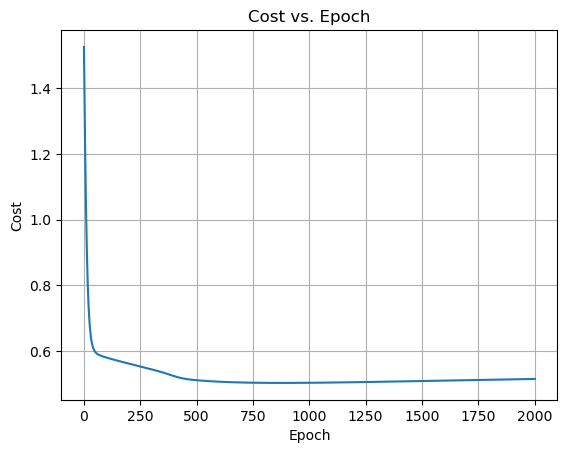

In [43]:

# Generate epochs based on costs length
epochs = range(1, len(costs) + 1)

# Plot
plt.plot(epochs, costs)
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('Cost vs. Epoch')
plt.grid(True)
plt.show()

need to explain this